#Import Library

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import os
import shutil
import pickle
from google.colab import files
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
import tensorflow_addons as tfa
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers.core import Activation
from keras.callbacks import ReduceLROnPlateau
from datetime import datetime
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from PIL import Image
import cv2
from tensorflow.keras.applications import ResNet50
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback

from skimage import io
from skimage.transform import resize

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#Init Program

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Unzip Dataset

In [ ]:
! unzip '/content/drive/MyDrive/Capstone/train-preprocess4.zip' -d .

Streaming output truncated to the last 5000 lines.
  inflating: ./train-preprocess4/leaf spot/_53_7564.png  
  inflating: ./train-preprocess4/leaf spot/_53_7833.png  
  inflating: ./train-preprocess4/leaf spot/_53_7858.png  
  inflating: ./train-preprocess4/leaf spot/_53_8223.png  
  inflating: ./train-preprocess4/leaf spot/_53_8413.png  
  inflating: ./train-preprocess4/leaf spot/_54_1183.png  
  inflating: ./train-preprocess4/leaf spot/_54_1223.png  
  inflating: ./train-preprocess4/leaf spot/_54_2135.png  
  inflating: ./train-preprocess4/leaf spot/_54_234.png  
  inflating: ./train-preprocess4/leaf spot/_54_2996.png  
  inflating: ./train-preprocess4/leaf spot/_54_363.png  
  inflating: ./train-preprocess4/leaf spot/_54_5082.png  
  inflating: ./train-preprocess4/leaf spot/_54_5525.png  
  inflating: ./train-preprocess4/leaf spot/_54_5716.png  
  inflating: ./train-preprocess4/leaf spot/_54_6267.png  
  inflating: ./train-preprocess4/leaf spot/_54_6420.png  
  inflating: ./train-pr

#Support Function

In [ ]:
from tensorflow.keras.callbacks import Callback

class StopTrainingCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 0.80:
            print("Validation accuracy reached 0.80 or higher. Stopping training.")
            self.model.stop_training = True

In [ ]:
def callbacks(filename):
  es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)
  reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                          factor = 0.3,
                          patience = 3,
                          min_lr = 1e-6,
                          mode = 'min',
                          verbose = 1)
  mc = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  stop_training_callback = StopTrainingCallback()

  return [es, mc, reduce_lr, stop_training_callback]

In [ ]:
def predict_new_data(model, shape, path):
  labels = (train_generator.class_indices)
  labels = dict((v,k) for k,v in labels.items())

  img = load_img(path, target_size=shape)
  imgplot = plt.imshow(img)
  target = img_to_array(img)
  target = np.expand_dims(target, axis=0)
  target = np.vstack([target])
  target /= 255
  pred = model.predict(target)
  return labels[np.argmax(pred, axis=1)[0]]

In [ ]:
def save_model(name, model, model_dir):
  path = os.path.join(model_dir, name)
  if os.path.isdir(path):
    print('\nReplacing the model with the new One\n')
    shutil.rmtree(path, ignore_errors=True)

  model.save(path)
  print("Export path: ", path)
  print(os.listdir(path))

#Prepare Data

In [ ]:
image_shape = 255
datagen = ImageDataGenerator(
    rotation_range=20,  # rotation
    width_shift_range=0.1,  # horizontal shift
    height_shift_range=0.1,  # vertical shift
    zoom_range=0.1,  # zoom
    rescale=1.0/255,
    horizontal_flip=True,  # horizontal flip
    vertical_flip=True,  # vertical flip
    brightness_range=[0.8, 1.2],  # brightness
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

batch_size = 32

train_generator = datagen.flow_from_directory(
    '/content/train-preprocess4',
    target_size=(image_shape, image_shape),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = val_datagen.flow_from_directory(
    '/content/train-preprocess4',
    target_size=(image_shape, image_shape),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 7993 images belonging to 5 classes.
Found 1995 images belonging to 5 classes.


In [ ]:
train_generator.class_indices

{'healthy': 0, 'leaf curl': 1, 'leaf spot': 2, 'whitefly': 3, 'yellowish': 4}

#Build Model

In [ ]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

###Model 1 (DenseNet121)-0.80 val acc

In [ ]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
model1 = Sequential()
model1.add(DenseNet121(input_shape=(image_shape, image_shape, 3), include_top=False, weights='imagenet'))
model1.add(GlobalAveragePooling2D())
model1.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
model1.add(Dense(5, activation='softmax'))

In [ ]:
model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.001),
               optimizer=Adam(learning_rate=2e-4),
               metrics=['accuracy'])

In [ ]:
history1 = model1.fit(train_generator,
                            validation_data = validation_generator,
                            epochs= 30,
                            batch_size = 32,
                            steps_per_epoch = STEP_SIZE_TRAIN,
                            validation_steps = STEP_SIZE_VALID,
                            callbacks=callbacks("Model_DenseNet121.h5")
                            )

Epoch 1/30
249/249 [==============================] - ETA: 0s - loss: 73.7694 - accuracy: 0.8877
Epoch 1: val_accuracy improved from -inf to 0.76613, saving model to Model_DenseNet121.h5
249/249 [==============================] - 323s 941ms/step - loss: 73.7694 - accuracy: 0.8877 - val_loss: 12.1896 - val_accuracy: 0.7661 - lr: 2.0000e-04
Epoch 2/30
249/249 [==============================] - ETA: 0s - loss: 2.3077 - accuracy: 0.9641
Epoch 2: val_accuracy did not improve from 0.76613
249/249 [==============================] - 218s 876ms/step - loss: 2.3077 - accuracy: 0.9641 - val_loss: 1.4463 - val_accuracy: 0.7157 - lr: 2.0000e-04
Epoch 3/30
249/249 [==============================] - ETA: 0s - loss: 0.6233 - accuracy: 0.9634
Epoch 3: val_accuracy did not improve from 0.76613
249/249 [==============================] - 216s 867ms/step - loss: 0.6233 - accuracy: 0.9634 - val_loss: 1.4774 - val_accuracy: 0.6482 - lr: 2.0000e-04
Epoch 4/30
249/249 [==============================] - ETA: 0s

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
label_types = []
for category in train_generator.class_indices:
  label_types.append(category)
label_types

['healthy', 'leaf curl', 'leaf spot', 'whitefly', 'yellowish']

In [ ]:
y_test = validation_generator.classes
y_pred = model1.predict_generator(validation_generator)
y_pred = tf.argmax(y_pred, axis=1)

<ipython-input-26-1f97d7f25348>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model1.predict_generator(validation_generator)


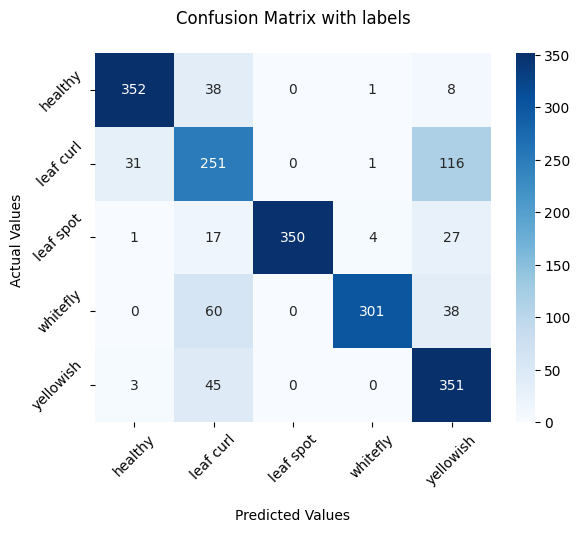

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred)


ax = sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')

ax.set_title('Confusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(label_types, rotation=45)
ax.yaxis.set_ticklabels(label_types, rotation=45)

plt.show()

In [ ]:
def normalize_image(image):
    height, width, _ = image.shape
    norm_size = max(height, width)
    add_h = norm_size - height
    add_w = norm_size - width
    start_add_h = add_h // 2
    start_add_w = add_w // 2
    new_img = np.full((norm_size, norm_size, 3), 255, dtype=np.uint8)
    new_img[start_add_h:start_add_h + height, start_add_w:start_add_w + width, :] = image
    return new_img

def preprocessing(image):
  img = normalize_image(image)
  img = cv2.resize(img, (300, 300), interpolation = cv2.INTER_AREA)
  return np.array(img)

1/1 [==============================] - 4s 4s/step


'whitefly'

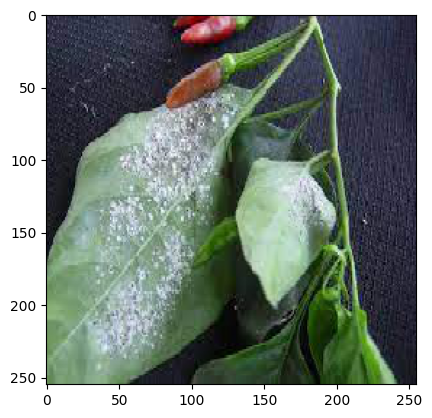

In [ ]:
predict_new_data(new_model, (255,255), '/content/drive/MyDrive/chili whitefly.jpg')

In [ ]:
save_model("Densenet121-0.80val", model1, "/content/drive/MyDrive/Capstone/Chili/Model")

Export path:  /content/drive/MyDrive/Capstone/Chili/Model/Densenet121-0.80val
['variables', 'assets', 'fingerprint.pb', 'saved_model.pb', 'keras_metadata.pb']


In [ ]:
new_model = tf.keras.models.load_model('/content/Model_DenseNet121.h5')

In [ ]:
new_model = tf.keras.models.load_model('/content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Code/Chili/Model/Densenet121-0.80val')

In [ ]:
new_model.save('/content/drive/Shareddrives/Teman Tani/Capstone 2023/Machine Learning/Code/Chili/Model/Chili_Densenet121-0.80val.h5')